In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from tqdm.auto import tqdm
import os 

model_names = ['Llama3.2_1B', 'Llama3.1_8B',
                     'gemma-2-2b-it', 'gemma-2-9b-it',
                     'Phi-3.5-mini-instruct', 'Phi-3-medium-128k-instruct',
                    # 'OLMo-1B-hf', 'OLMo-7B-0724-Instruct-hf',
                     'Ministral-8B-Instruct-2410', 'Mistral-Nemo-Instruct-2407',
                     'OLMo-2-1124-7B-Instruct', 'OLMo-2-1124-13B-Instruct']
layers_counts = [16, 32, 
                 26, 42, 
                 32, 40,
                #  16, 32,
                 36, 40,
                 32, 40]

model_formal_names = ['Llama3 1B', 'Llama3 8B', 
                      'Gemma2 2B', 'Gemma2 9B', 
                      'Phi3 4B', 'Phi3 14B',
                      #'OLMo 1B', 'OLMo 7B', 
                      'Mistral 8B', 'Mistral 12B',
                      'OLMo2 7B', 'OLMo2 13B']

model_hf_names = ['meta-llama/Llama-3.2-1B-Instruct', 'meta-llama/Llama-3.1-8B-Instruct', 
                     'google/gemma-2-2b-it', 'google/gemma-2-9b-it', 
                     'microsoft/Phi-3.5-mini-instruct', 'microsoft/Phi-3-medium-128k-instruct', 
                    #  'allenai/OLMo-1B-hf', 'allenai/OLMo-7B-0724-Instruct-hf', 
                     'mistralai/Ministral-8B-Instruct-2410', 'mistralai/Mistral-Nemo-Instruct-2407',
                     'allenai/OLMo-2-1124-7B-Instruct', 'allenai/OLMo-2-1124-13B-Instruct', ]

# sort the models based on the layer counts

# get the sorted indices based on the layer counts
indices = np.argsort(layers_counts)

model_names = [model_names[i] for i in indices]
model_formal_names = [model_formal_names[i] for i in indices]
model_hf_names = [model_hf_names[i] for i in indices]
layers_counts = [layers_counts[i] for i in indices]

print(model_names, model_formal_names, layers_counts)

probe_location_to_formal_name = {3: 'Attention Output', 6: 'MLP Output', 7: 'Hidden State'}

os.makedirs(f'figs/shared/', exist_ok=True)

FONT_SIZE = 16


['Llama3.2_1B', 'gemma-2-2b-it', 'Llama3.1_8B', 'Phi-3.5-mini-instruct', 'OLMo-2-1124-7B-Instruct', 'Ministral-8B-Instruct-2410', 'Phi-3-medium-128k-instruct', 'Mistral-Nemo-Instruct-2407', 'OLMo-2-1124-13B-Instruct', 'gemma-2-9b-it'] ['Llama3 1B', 'Gemma2 2B', 'Llama3 8B', 'Phi3 4B', 'OLMo2 7B', 'Mistral 8B', 'Phi3 14B', 'Mistral 12B', 'OLMo2 13B', 'Gemma2 9B'] [16, 26, 32, 32, 32, 36, 40, 40, 40, 42]


In [7]:
%load_ext autoreload
%autoreload 2
from plotters_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
emotion_to_id, id_to_emotion, appraisals_to_id, id_to_appraisals, appraisal_to_formal_name, appraisal_to_formal_name_without_newline, appraisals, _, _, _, _ = load_emotion_and_appraisals_list(model_names[0])

In [9]:
print("Emotions to study:", emotion_to_id)
print("Appraisals to study:", appraisals_to_id)
print('Appraisal Formal Names:', appraisal_to_formal_name)


Emotions to study: {'anger': 0, 'boredom': 1, 'disgust': 2, 'fear': 3, 'guilt': 4, 'joy': 5, 'neutral': 6, 'pride': 7, 'relief': 8, 'sadness': 9, 'shame': 10, 'surprise': 11, 'trust': 12}
Appraisals to study: {'predict_event': 0, 'pleasantness': 1, 'other_responsblt': 2, 'chance_control': 3, 'suddenness': 4, 'familiarity': 5, 'unpleasantness': 6, 'goal_relevance': 7, 'self_responsblt': 8, 'predict_conseq': 9, 'goal_support': 10, 'urgency': 11, 'self_control': 12, 'other_control': 13, 'accept_conseq': 14, 'standards': 15, 'social_norms': 16, 'attention': 17, 'not_consider': 18, 'effort': 19}
Appraisal Formal Names: {'other_responsblt': 'other\nagency', 'predict_event': 'predictability', 'chance_control': 'situational\ncontrol', 'self_responsblt': 'self\nagency', 'pleasantness': 'pleasantness', 'suddenness': 'suddenness', 'familiarity': 'familiarity', 'unpleasantness': 'unpleasantness', 'goal_relevance': 'goal\nrelevance', 'predict_conseq': 'predict\nconseq', 'goal_support': 'goal\nsuppo

In [10]:
import pandas as pd
train_data = pd.read_csv('data/enVent_gen_Data.csv', encoding='ISO-8859-1')
raw_texts = train_data['hidden_emo_text'].to_list()

## dataset distribution

In [11]:
values = []
for model_name in model_names:
    unfiltered_labels, labels = torch.load(f'outputs/{model_name}/unfiltered_emotion_logits.pt', weights_only=False)
    values.append(unfiltered_labels)
        
values.insert(0, labels)
values = torch.stack(values, dim=0)

for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        values[i, j] = formal_emotion_to_id[id_to_emotion[values[i, j].item()]]
        

# freq_sorted_on_rows = torch.empty_like(values)
# for i in range(values.shape[0]):
#     row = values[i]
#     v = torch.unique(row, return_counts=True)
#     indices = v[0].sort(dim=0, descending=True).indices
#     v_ = v[0][indices]
#     c_ = v[1][indices]
#     ii = 0
#     for j, c in enumerate(c_):
#         freq_sorted_on_rows[i, ii:ii+c] = v_[j]
#         ii += c
    
freq_sorted_on_cols = torch.empty_like(values)
freq_sorted_on_cols[0, :] = values[0, :]
for i in range(values.shape[1]):
    col = values[1:, i]
    v = torch.unique(col, return_counts=True)
    indices = v[1].sort(dim=0, descending=True).indices
    v_ = v[0][indices]
    c_ = v[1][indices]
    ii = 0
    for j, c in enumerate(c_):
        freq_sorted_on_cols[1+ii:1+ii+c, i] = v_[j]
        ii += c
        

print(values.shape)

frequency = torch.zeros((len(formal_emotion_to_id), values.shape[0]))
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        frequency[values[i, j].item(), i] += 1


torch.Size([11, 6600])


In [12]:
len(model_formal_names)

10

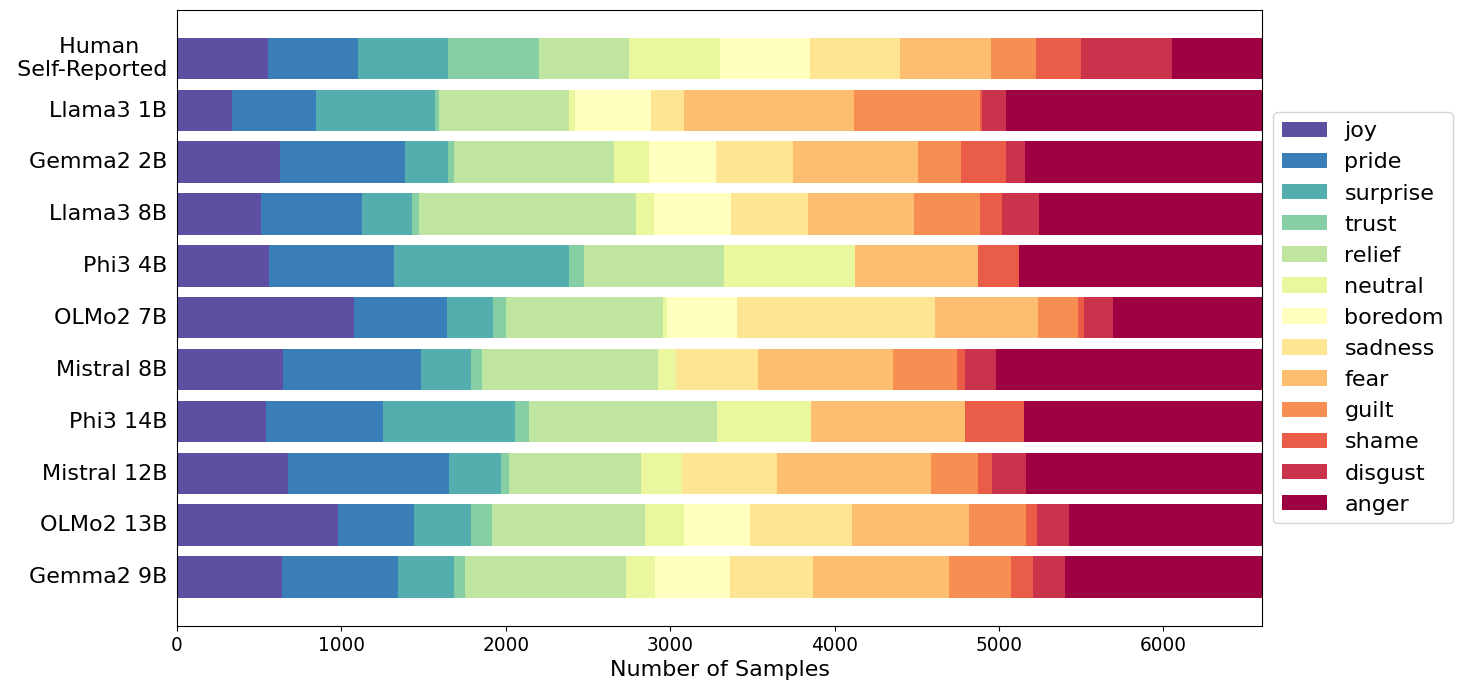

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as mcolors

plt.figure(figsize=(14, 8))
bar_width = 0.35
for i in range(frequency.shape[0]):
    val = frequency[:i].sum(dim=0)
    plt.barh(np.arange(frequency.shape[1]), frequency[i], left=val, label=id_to_formal_emotion[i], color=emotion_to_color[id_to_formal_emotion[i]], linewidth=0.5)

plt.yticks(np.arange(frequency.shape[1]), [' Human    \n Self-Reported'] + model_formal_names, fontsize=FONT_SIZE, va='center', ha='right')
# turn off the ticks
plt.tick_params(axis='y', which='both', left=False, right=False)
# invert the y axis
plt.gca().invert_yaxis()
plt.xlabel("Number of Samples", fontsize=FONT_SIZE)
# plt.ylabel("Predictions by Different Models")

plt.legend(loc='center left', bbox_to_anchor=(1., 0.5), fontsize=FONT_SIZE)
# plt.title("Predictions of Emotions by Models")

plt.xlim(0, 6600)
plt.xticks(fontsize=FONT_SIZE / 1.2)
plt.grid(False)
plt.savefig(f'figs/shared/emotion_distribution_models.pdf', bbox_inches='tight', dpi=300)


In [14]:
values = []
accuracies = []
for model_name in model_names:
    unfiltered_labels, labels = torch.load(f'outputs/{model_name}/unfiltered_emotion_logits.pt', weights_only=False)
    values.append(unfiltered_labels)
    accuracies.append((unfiltered_labels == labels).float().mean().item())

accuracies = torch.tensor(accuracies)
        
values.insert(0, labels)
values = torch.stack(values, dim=0)

for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        values[i, j] = formal_emotion_to_id[id_to_emotion[values[i, j].item()]]
        
print(values.shape)

frequency = torch.zeros((len(formal_emotion_to_id), values.shape[0]))
for i in range(values.shape[0]):
    for j in range(values.shape[1]):
        frequency[values[i, j].item(), i] += 1


torch.Size([11, 6600])


0 Llama3 1B
1 Gemma2 2B
2 Llama3 8B
3 Phi3 4B
4 OLMo2 7B
5 Mistral 8B
6 Phi3 14B
7 Mistral 12B
8 OLMo2 13B
9 Gemma2 9B


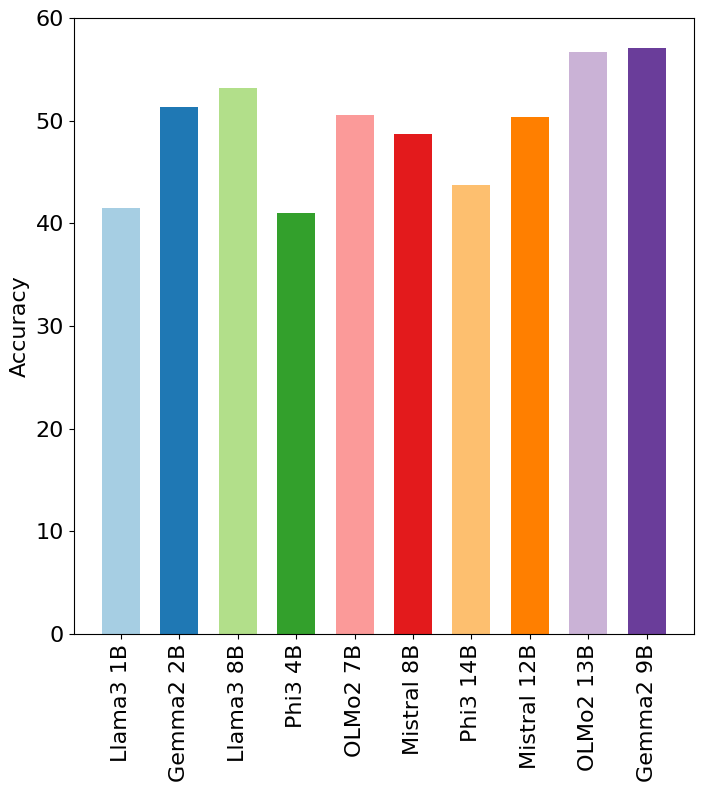

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = sns.color_palette("Paired", len(accuracies))
bar_width = 0.65
# ax.grid(zorder=0)
# ax.xaxis.grid(False)
# ax.yaxis.grid(True)

for i in range(len(accuracies)):
    print(i, model_formal_names[i])
    ax.bar(i, accuracies[i] * 100, label=model_formal_names[i], color=colors[i], width = bar_width)

xticks = np.arange(len(model_formal_names))
ax.set_xticks(xticks, model_formal_names, rotation=90, fontsize=FONT_SIZE)
ax.set_ylabel("Accuracy", fontsize=FONT_SIZE)
ax.set_ylim(0, 60)
# set font size
ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)


# ax.set_title("Accuracy of Predictions by Models")

# ax.legend(loc='best', bbox_to_anchor=(1.1, 1.1))
plt.savefig(f'figs/shared/emotion_accuracy_models.pdf', bbox_inches='tight', dpi=300)
plt.show()
    

In [16]:
def justify_strings(strings, width):
    justified_lines = []
    
    for string in strings:
        # Break string into lines that fit within the width
        lines = []
        while len(string) > width:
            # Find the last space within the width to break the line
            break_point = string.rfind(' ', 0, width)
            if break_point == -1:  # No space found, force break
                break_point = width
            lines.append(string[:break_point])
            string = string[break_point:].lstrip()  # Remove leading spaces from the next line
        lines.append(string)  # Add the remaining part
        lines = [line for line in lines] #line.ljust(width)
        
        # Pad each line to the width
        justified_lines.append('\n'.join(lines))
    
    return justified_lines

## Probing Effect

In [17]:

locs_to_probe = [3, 6, 7]
max_layer_count = max(layers_counts)
values_probe = torch.zeros((len(locs_to_probe), len(model_names), max_layer_count))
values_probe = values_probe.fill_(np.nan)

for i, (model_name, layer_count) in enumerate(zip(model_names, layers_counts)):
    layers = list(range(layer_count))
    try:
        tokens_ = [-1]
        v = process_emotion_probe_results(model_name, layers, locs_to_probe, tokens_)
    except Exception as e:
        tokens_ = list(range(-1, -6, -1))
        v = process_emotion_probe_results(model_name, layers, locs_to_probe, tokens_)
    
    v = v[:, tokens_.index(-1)]
    for j, _ in enumerate(locs_to_probe):
         for k, _ in enumerate(layers):
            values_probe[j, i, k] = v[j, k]

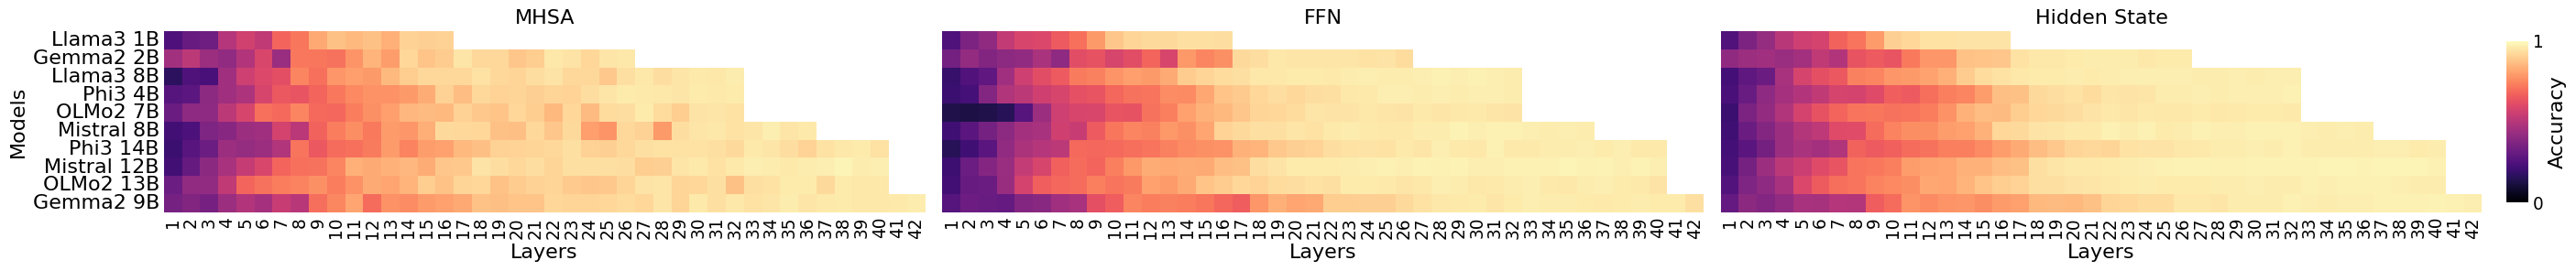

In [18]:
layers = list(range(max_layer_count))

plot_heatmap(values_probe, suptitle = None, #f'Probing Results',
             titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = FONT_SIZE,
             xticks = np.arange(len(layers)) + 0.5, xtick_labels = (torch.tensor(layers) + 1).numpy(),
             yticks = np.arange(len(model_formal_names)) + 0.5, ytick_labels = model_formal_names,
             yticks_rotation = 0, xticks_rotation = 90,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Models',
             cmap='magma', cmap_label='Accuracy', cmap_shrink=1.0, cmap_aspect=7.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[-0.1, 1.0], cbar_ytick_labels=[0, 1],
             figsize=(28, 5), save_path = f'shared/emotion_probe_heatmap')

## Zero-Intervention 

In [19]:

locs_to_probe = [3, 6, 7]
span_zero = 3
tokens = [[-1]] #['all']  # 
max_layer_count = max(layers_counts) - span_zero + 1

values_zero = torch.zeros((len(locs_to_probe), len(model_names), max_layer_count))
values_zero = values_zero.fill_(np.nan)

for i, (model_name, layer_count) in enumerate(zip(model_names, layers_counts)):
    layers_centers = list(range(span_zero // 2, layer_count - span_zero // 2))
    for j, loc in enumerate(locs_to_probe):
        try:
            v = process_zero_intervention(model_name, [loc], tokens, layers_centers, span_zero)
            v = v[:, tokens.index([-1])] # 'all'            
            for k, _ in enumerate(layers_centers):
                values_zero[j, i, k] = v[0, k]
        except Exception as e:
            print(e)
    

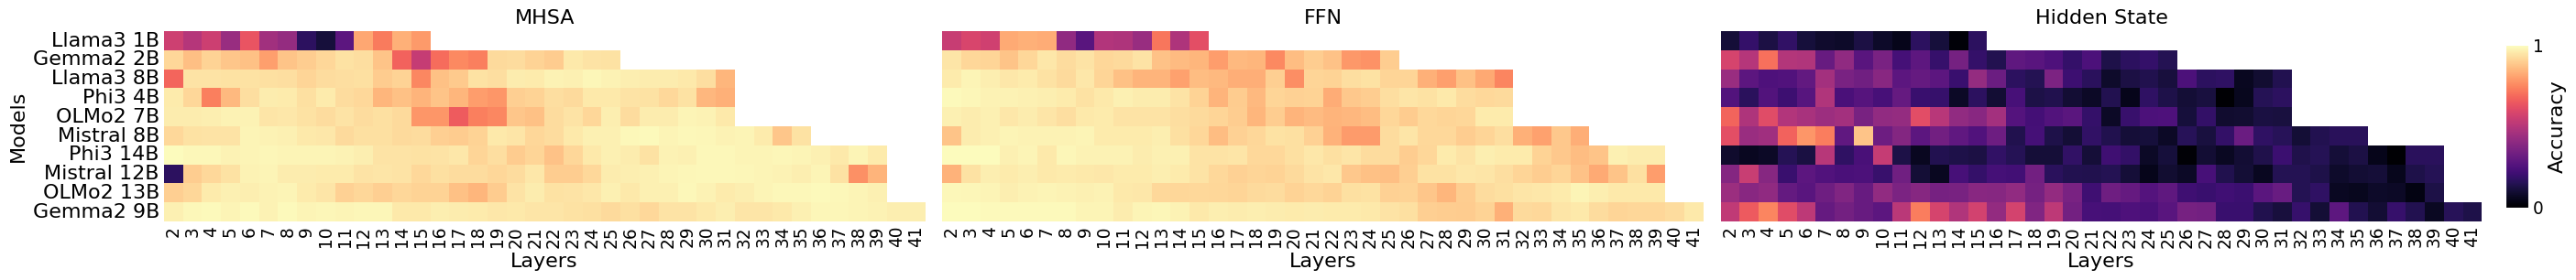

In [20]:
max_layer_count = max(layers_counts)
layers_centers = list(range(span_zero // 2, max_layer_count - span_zero // 2)) 
# normalize_row_wise_with_nan_mask(
plot_heatmap(values_zero, suptitle = None, #f'Zero-Intervention (with span {span_zero})', 
             titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = FONT_SIZE,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(model_formal_names)) + 0.5, ytick_labels = model_formal_names,
             yticks_rotation = 0, xticks_rotation = 90,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Models',
             cmap='magma', cmap_label='Accuracy', cmap_shrink=1.0, cmap_aspect=7.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[-0.1, 1.0], cbar_ytick_labels=[0, 1],
             figsize=(28, 5), save_path = f'shared/emotion_zero_heatmap')

## Random-Intervention 

In [26]:

locs_to_probe = [3, 6, 7]
span_random = 3
seed = 100
tokens = [[-1]] #['all']  # 
max_layer_count = max(layers_counts) - span_random + 1

values_random = torch.zeros((len(locs_to_probe), len(model_names), max_layer_count))
values_random = values_random.fill_(np.nan)

for i, (model_name, layer_count) in enumerate(zip(model_names, layers_counts)):
    layers_centers = list(range(span_random // 2, layer_count - span_random // 2))
    for j, loc in enumerate(locs_to_probe):
        try:
            v = process_random_intervention(model_name, [loc], tokens, layers_centers, span_random, seed)
            v = v[:, tokens.index([-1])] # 'all'            
            for k, _ in enumerate(layers_centers):
                values_random[j, i, k] = v[0, k]
        except Exception as e:
            print(model_name, e)
            print(e)
    

clean logits loaded with shape: torch.Size([2740, 13])
--------------------------------------------
data loaded with shape: torch.Size([2740, 13])
--------------------------------------------
clean logits loaded with shape: torch.Size([2740, 13])
--------------------------------------------
data loaded with shape: torch.Size([2740, 13])
--------------------------------------------
clean logits loaded with shape: torch.Size([2740, 13])
--------------------------------------------
data loaded with shape: torch.Size([2740, 13])
--------------------------------------------
clean logits loaded with shape: torch.Size([3387, 13])
--------------------------------------------
data loaded with shape: torch.Size([3387, 13])
--------------------------------------------
clean logits loaded with shape: torch.Size([3387, 13])
--------------------------------------------
data loaded with shape: torch.Size([3387, 13])
--------------------------------------------
clean logits loaded with shape: torch.Si

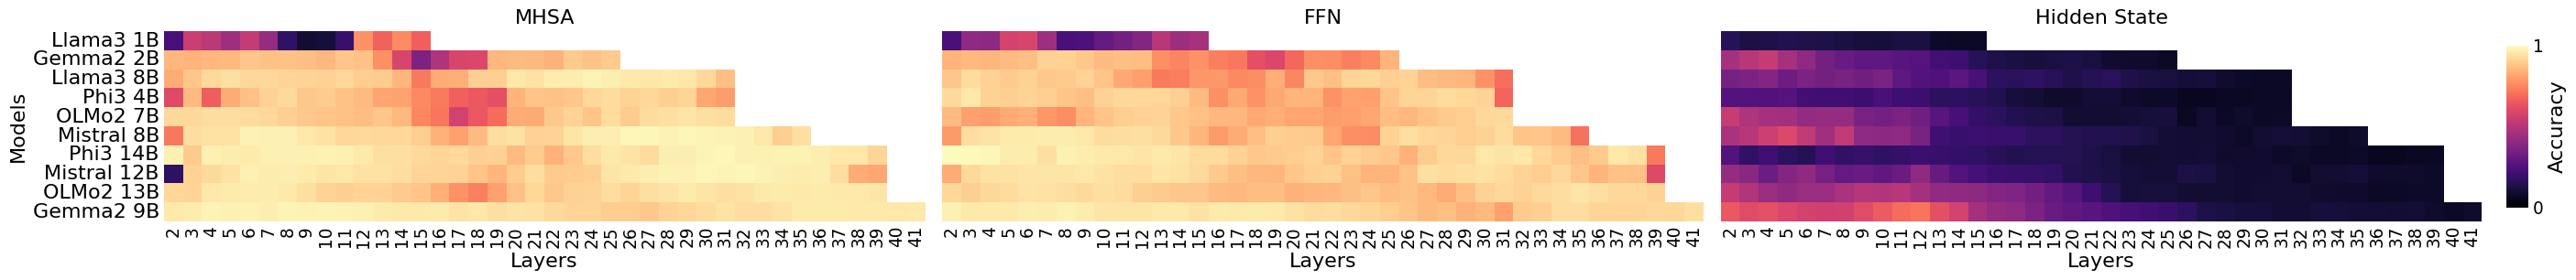

In [27]:
max_layer_count = max(layers_counts)
layers_centers = list(range(span_random // 2, max_layer_count - span_random // 2)) 
# normalize_row_wise_with_nan_mask(
plot_heatmap(values_random, suptitle = None, 
             titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = FONT_SIZE,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(model_formal_names)) + 0.5, ytick_labels = model_formal_names,
             yticks_rotation = 0, xticks_rotation = 90,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Models',
             cmap='magma', cmap_label='Accuracy', cmap_shrink=1.0, cmap_aspect=7.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[-0.1, 1.0], cbar_ytick_labels=[0, 1],
             figsize=(28, 5), save_path = f'shared/emotion_random_heatmap')

## Emotion Transfer using Patching 

In [28]:
num_exps = 200
locs_to_probe = [3, 6, 7]
tokens = [-1] 
span_patch = 5
max_layer_count = max(layers_counts) - span_patch + 1
values_patch = torch.zeros((len(locs_to_probe), len(model_names), max_layer_count))
values_patch = values_patch.fill_(np.nan)

for i, (model_name, layer_count) in enumerate(zip(model_names, layers_counts)):
    layers_centers = list(range(span_patch // 2, layer_count - span_patch // 2))
    print(layers_centers)
    v = process_activation_patching(model_name, num_exps, locs_to_probe, tokens, layers_centers, span_patch)
    v = v[:, tokens.index(-1)][..., 0]
    
    print(values_patch.shape, v.shape)
    
    for j, _ in enumerate(locs_to_probe):
        for k, _ in enumerate(layers_centers):
            values_patch[j, i, k] = v[j, k]
    

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 12])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 22])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 28])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 28])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 28])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 32])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 36])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 36])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 36])
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([3, 10, 38]) torch.Size([3, 38])


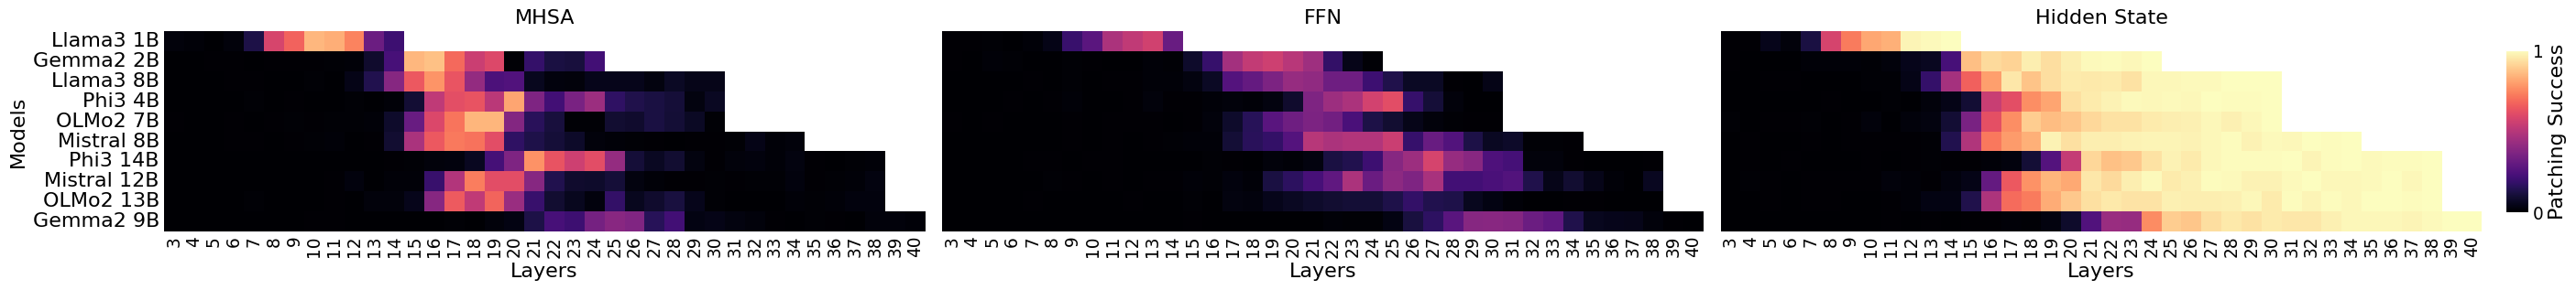

In [29]:
max_layer_count = max(layers_counts)
layers_centers = list(range(span_patch // 2, max_layer_count - span_patch // 2)) 

plot_heatmap(values_patch, suptitle = None, #f'Patching (with span {span_patch})', 
             titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = FONT_SIZE,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(model_formal_names)) + 0.5, ytick_labels = model_formal_names,
             yticks_rotation = 0, xticks_rotation = 90,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Models',
             cmap='magma', cmap_label='Patching Success', cmap_shrink=1.0, cmap_aspect=7.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[-0.1, 1.0], cbar_ytick_labels=[0, 1],
             figsize=(28, 5), save_path = f'shared/emotion_patch_heatmap')


In [36]:
max_layer_count = max(layers_counts)
values = torch.zeros((8, len(locs_to_probe), len(model_names), max_layer_count))
values = values.fill_(np.nan)
values[2] = values_probe
values[3, :,  :, span_zero // 2:max_layer_count - span_zero // 2] = values_zero
values[4, :, :,  span_random // 2:max_layer_count - span_random // 2] = values_random
values[5, :, :,  span_patch // 2:max_layer_count - span_patch // 2] = values_patch

values = values.permute(1, 2, 0, 3)
values = values.reshape(len(locs_to_probe), len(model_names) * 8, max_layer_count)

In [37]:
values.shape

torch.Size([3, 80, 42])

80
80


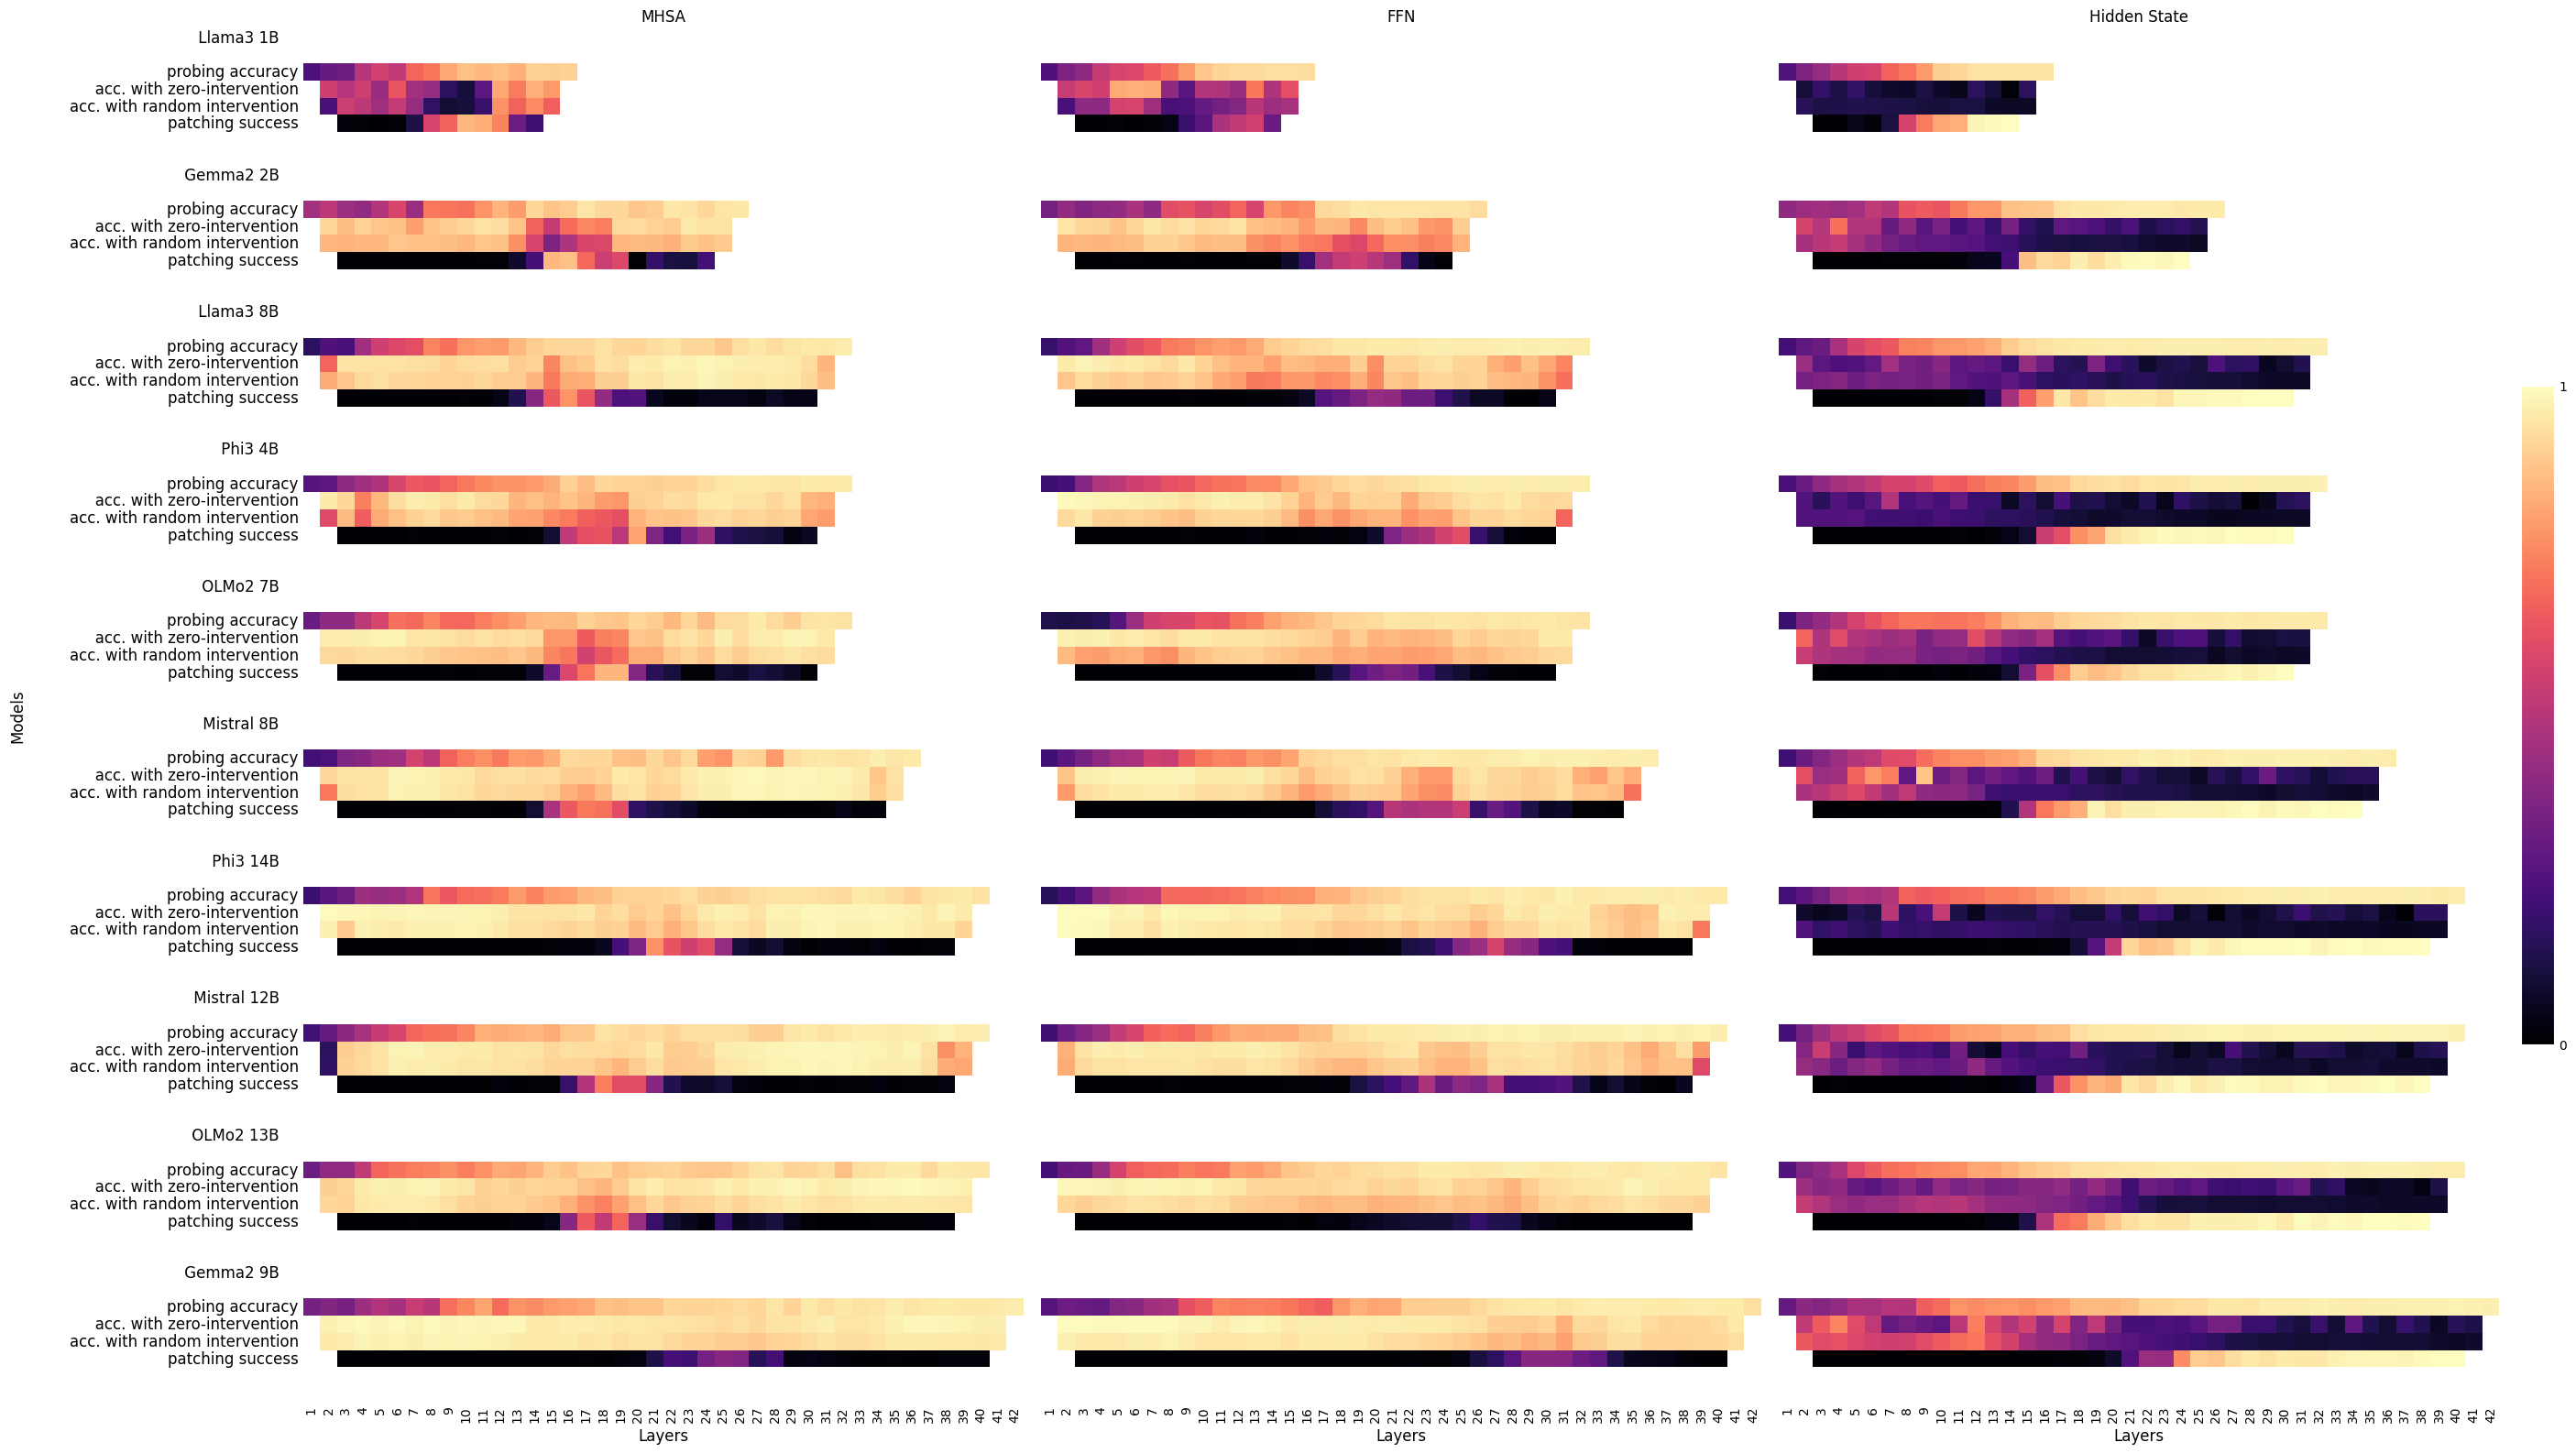

In [48]:
y_labels = [[f'     {model_name}    ', '', '    probing accuracy', '       acc. with zero-intervention', '        acc. with random intervention', 
             '        patching success', '', ''] for model_name in model_formal_names]
y_labels = [item for sublist in y_labels for item in sublist]
print(len(y_labels))

print(len(y_labels))
plot_heatmap(values, suptitle = f'', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = FONT_SIZE - 4,
             xticks = np.arange(max_layer_count) + 0.5, xtick_labels = (torch.tensor(list(range(max_layer_count))) + 1).numpy(),
             yticks = np.arange(8 * len(model_formal_names)) + 0.5, ytick_labels = y_labels,
             yticks_rotation = 0, xticks_rotation = 90,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Models',
             cmap='magma', cmap_label='', cmap_shrink=1.0, cmap_aspect=20.0, cmap_fraction=0.015, cmap_pad=0.01,
             cbar_yticks=[-0.1, 1], cbar_ytick_labels=[0, 1],
             figsize=(28, 16), save_path = f'shared/emotion_all_heatmap')



